# Messung der RIR mit Impulsanregung

In [5]:
%matplotlib widget
import pyrato
import pyfar as pf
import numpy as np
import matplotlib.pyplot as plt
from utils.io import read_ita
from utils.edc import truncated_schroeder_integration
from scipy.signal import find_peaks
from utils.plot import attach_fractional_octave_ticker
np.seterr(divide='ignore');

## Importiere die gemessene Raumimpulsanwort

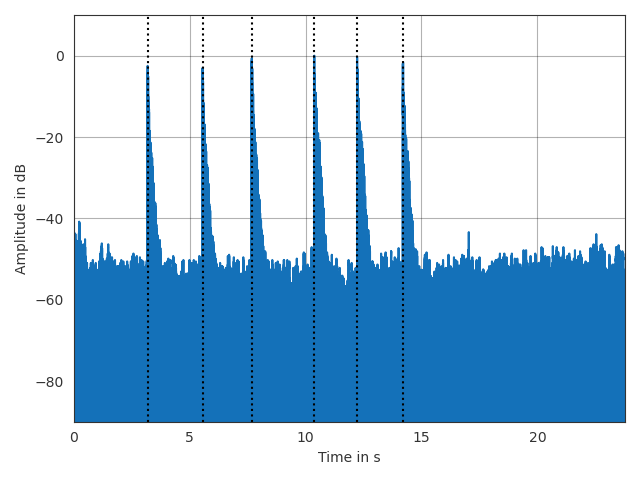

In [6]:
RIRs_impulse = pf.io.read_audio('../data/RIR_rec_impulse.wav')
sampling_rate = RIRs_impulse.sampling_rate
RIRs_impulse = pf.dsp.normalize(RIRs_impulse)

peak_distance = 0.6*sampling_rate
peaks = find_peaks(
    np.squeeze(RIRs_impulse.time),
    threshold=10**(-20/20),
    distance=peak_distance)[0]

t_peaks = peaks/sampling_rate

plt.figure()
ax = pf.plot.time(RIRs_impulse, dB=True)
for t_peak in t_peaks:
    ax.axvline(t_peak, linestyle=':', color='k')

time_before_impulse = 0.05
expected_rt = .6
start_sample_rirs = ((t_peaks - time_before_impulse)*sampling_rate).astype(int)

n_samples = np.min(
    np.diff(np.r_[0, start_sample_rirs, RIRs_impulse.n_samples]))
data = np.zeros((len(peaks), n_samples), float)

for ch, start_sample in enumerate(start_sample_rirs):
    end_sample = start_sample + n_samples
    data[ch] = RIRs_impulse.time[0, start_sample:end_sample]

RIRs_cropped = pf.Signal(data, sampling_rate)

# Geschnittene Impulsantwort

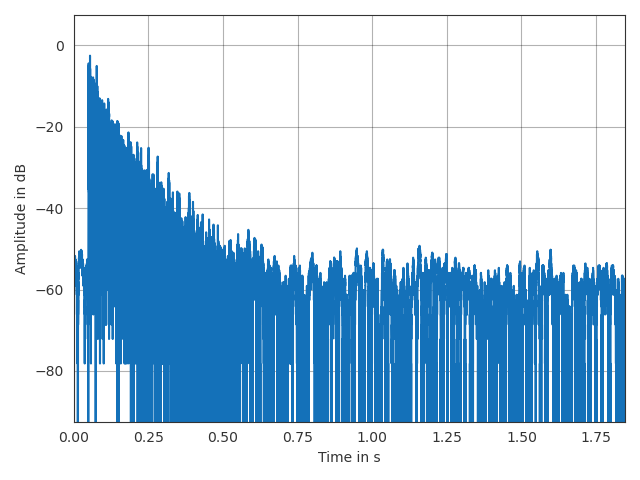

In [7]:
idx = 0
plt.figure()
ax = pf.plot.time(RIRs_cropped[idx], dB=True, label='RIR')

Bandpassfilterung in das 1 kHz Oktavbamd

In [8]:
RIR_bandpass = pf.dsp.normalize(
    pf.dsp.filter.fractional_octave_bands(
        RIRs_cropped[idx], 1, freq_range=[990, 1100]))

Die gemessene Raumimpulsantwort enthält additives Rauschen. Die Rauschleistung kann geschätzt werden nachdem die RIR abgeklungen ist.

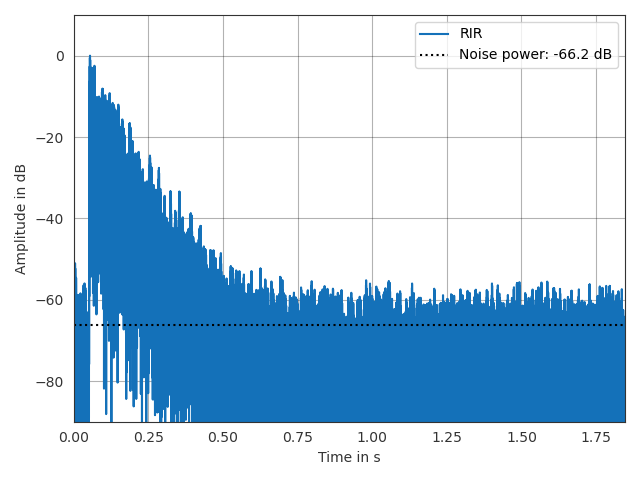

In [9]:
idx = 0
noise_power = float(pyrato.dsp._estimate_noise_energy(RIR_bandpass.time**2))
plt.figure()
ax = pf.plot.time(RIR_bandpass, dB=True, label='RIR')
ax.axhline(
    10*np.log10(noise_power),
    linestyle=':', color='k',
    label=f'Noise power: {10*np.log10(noise_power):.1f} dB')
ax.legend();

# Bestimmung der Abklingkurve

Die Abklingkurve kann aus der RIR bestimmt werden mittels der Schroeder Integration

$$ e(t) = \int_t^\infty h^2(\tau) d\tau = \int_0^\infty h^2(\tau) d\tau - \int_0^t h^2(\tau) d\tau$$

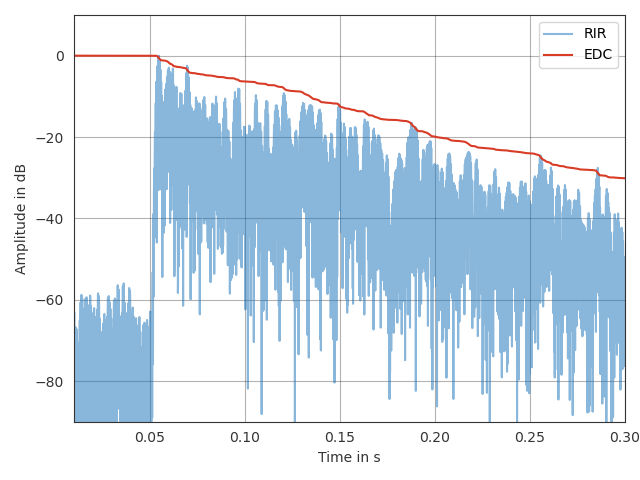

In [10]:
truncation_time = RIR_bandpass.times[-1]
edc = truncated_schroeder_integration(RIR_bandpass, truncation_time)

plt.figure()
ax = pf.plot.time(RIR_bandpass, dB=True, label='RIR', alpha=0.5)
pf.plot.time(edc/(edc.time[0, 0]), dB=True, log_prefix=10, label='EDC')
ax.legend()
ax.set_xlim(0.01, 0.3)
plt.legend();

Für die Schroeder Integration muss eine obere Integrationsgrenze $t_i$ festgelegt werden. 

$$ e(t) = \int_t^{t_i} h^2(\tau) d\tau $$

**Aufgabe: Bestimmen Sie die Integrationsgrenze $t_i$**

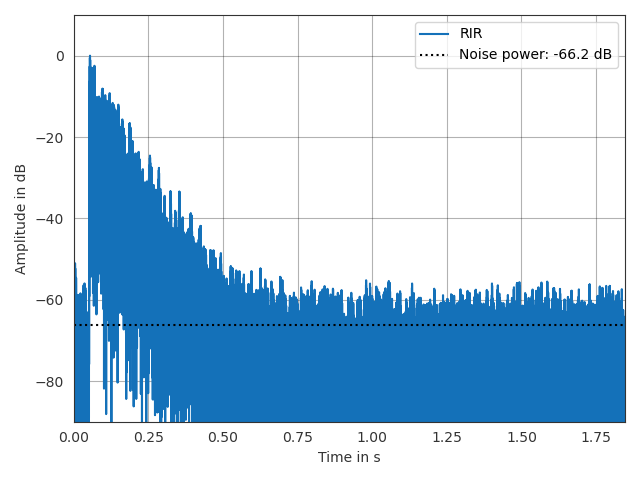

In [11]:
idx = 0
noise_power = float(pyrato.dsp._estimate_noise_energy(RIR_bandpass.time**2))
plt.figure()
ax = pf.plot.time(RIR_bandpass, dB=True, label='RIR')
ax.axhline(
    10*np.log10(noise_power),
    linestyle=':', color='k',
    label=f'Noise power: {10*np.log10(noise_power):.1f} dB')
ax.legend();

In [12]:
truncation_time = 0.5
edc = truncated_schroeder_integration(RIR_bandpass, truncation_time)

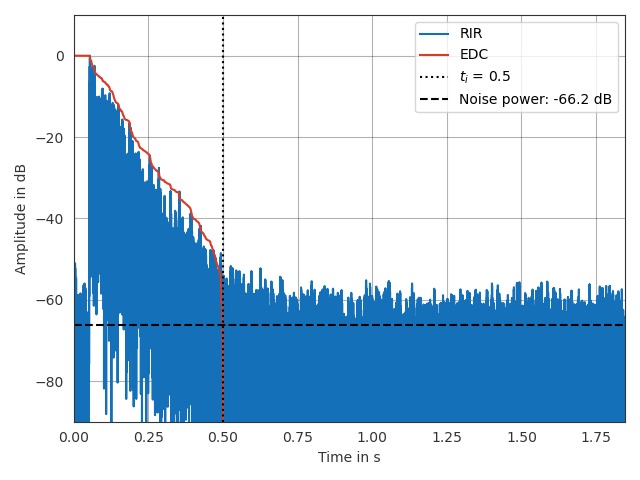

In [13]:
plt.figure()
ax = pf.plot.time(RIR_bandpass, dB=True, label='RIR')
pf.plot.time(edc/edc.time[0, 0], dB=True, log_prefix=10, label='EDC')
ax.axvline(
    truncation_time, label=f'$t_i$ = {truncation_time:.1f}',
    color='k', linestyle=':')
ax.axhline(
    10*np.log10(noise_power),
    linestyle='--', color='k',
    label=f'Noise power: {10*np.log10(noise_power):.1f} dB')
ax.legend()
plt.legend();

Die Intersection Time, die den Übergang der RIR ins Rauschen beschreibt lässt sich auch automatisiert mittels des Lundeby Algorithmus berechnen.

In [14]:
int_times = pyrato.intersection_time_lundeby(
    RIR_bandpass, freq='broadband')[0]
print(f"t_i = {float(int_times):.2f}")

t_i = 0.55


In [15]:
edc = truncated_schroeder_integration(RIR_bandpass, int_times)
edc = edc / edc.time[0, 0]

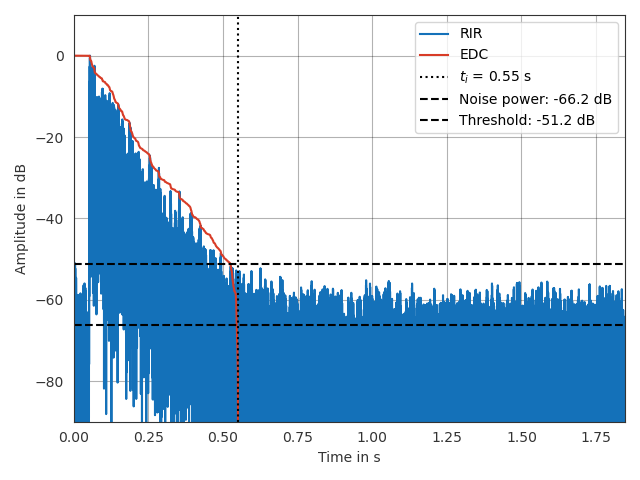

In [16]:
plt.figure()
ax = pf.plot.time(RIR_bandpass, dB=True, label='RIR')
pf.plot.time(edc, dB=True, log_prefix=10, label='EDC')
ax.axvline(
    float(int_times), label=f'$t_i$ = {float(int_times):.2f} s',
    color='k', linestyle=':')
ax.axhline(
    10*np.log10(noise_power),
    linestyle='--', color='k',
    label=f'Noise power: {10*np.log10(noise_power):.1f} dB')
ax.axhline(
    10*np.log10(noise_power)+15,
    linestyle='--', color='k',
    label=f'Threshold: {10*np.log10(noise_power)+15:.1f} dB')

plt.legend();

# Bestimmung der Nachhallzeit

Die Nachhallzeit wird mittels linearer Regression aus der logarithmischen Abklingkurve bestimmt.

$$ 10 \log_{10}(e(t)) = -\frac{60}{T_{20}} \cdot t + n$$

Die Nachhallzeit ist alleine von der Steigung der Geraden abhängig.
Für eine robuste Bestimmung von $T_{20}$ und $n$ wird die Minimierung der Fehlerquadrate verwendet.

In [17]:
interval = 20

In [18]:
reverberation_times, intercept = pyrato.reverberation_time_linear_regression(
    edc, return_intercept=True, T=f"T{interval}")
print(f"T{interval} = {float(reverberation_times):.2f} s")

T20 = 0.47 s


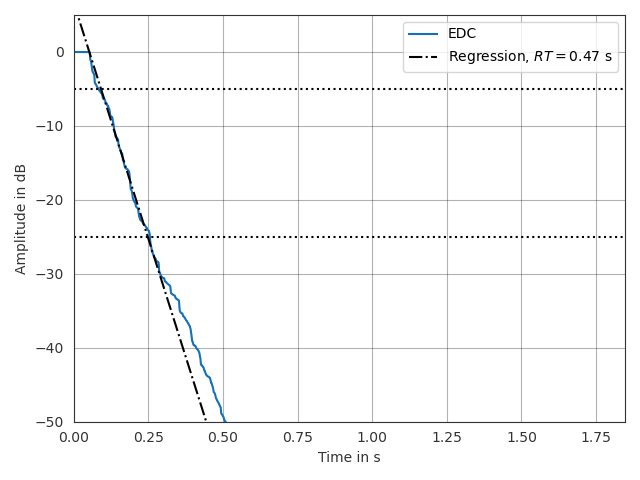

In [19]:
edc_model = 10*np.log10(
    intercept*np.exp(-13.8*edc.times/reverberation_times[0]))

plt.figure()
ax = pf.plot.time(edc, dB=True, log_prefix=10, label='EDC')
ax.plot(
    edc.times, edc_model, color='k', linestyle='-.',
    label=f'Regression, $RT={float(reverberation_times):.2f}$ s')
ax.set_ylim((-50, 5))
ax.axhline(-5, color='k', linestyle=':')
ax.axhline(-5-interval, color='k', linestyle=':')
plt.legend();

# Auswirkung der Richtcharakteristik

Lässt sich die Rotation der Quelle in den Messergebnissen erkennen?

In [20]:
band = 1e3
RIRs_bandpass = pf.dsp.filter.fractional_octave_bands(
    RIRs_cropped, 1, freq_range=np.array([0.9, 1.1])*band)

int_times = pyrato.intersection_time_lundeby(
    RIRs_cropped[0], freq='broadband')[0]
edcs = pyrato.energy_decay_curve_chu_lundeby(
    RIRs_bandpass, freq=band, normalize=True)

/Users/marco/ITA/teaching/Intensivkurs/2022_dega_block_room_acoustics/env/2022_dega_block_room_acoustics/lib/python3.9/site-packages/pyrato/edc.py:982: UserWarning: Lundeby algorithm was terminated after 30 iterations.
  warnings.warn(


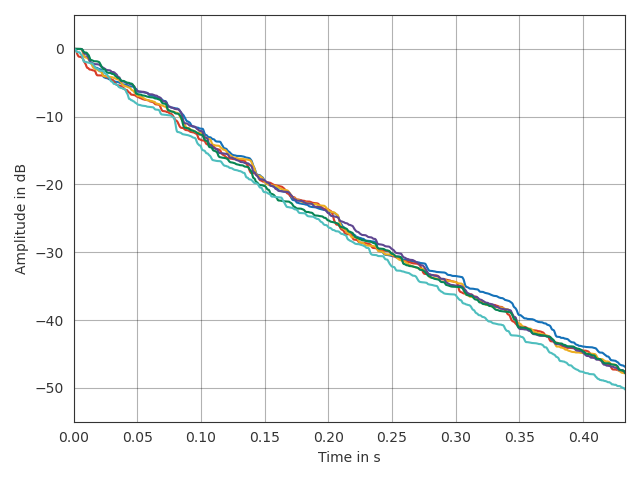

In [21]:
plt.figure()
ax = pf.plot.time(edcs, log_prefix=10, dB=True)
ax.set_xlim(0, np.min(int_times))
ax.set_ylim(-55, 5);

Relative std. 5.45 %


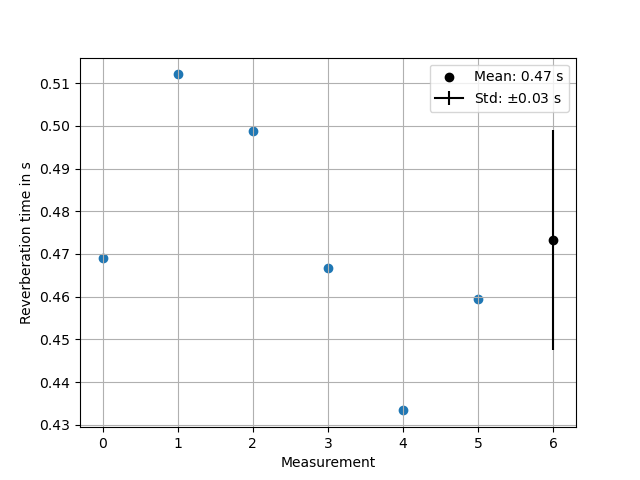

In [22]:
reverberation_times = pyrato.reverberation_time_linear_regression(edcs)

rt_mean = np.mean(reverberation_times)
rt_std = np.std(reverberation_times)

plt.figure()
ax = plt.axes()
ax.scatter(np.arange(0, reverberation_times.size), reverberation_times)
ax.scatter(reverberation_times.size, rt_mean, color='k', label=f'Mean: {rt_mean:.2f} s')
ax.errorbar(reverberation_times.size, rt_mean, rt_std, color='k', barsabove=True, label=f'Std: $\pm${rt_std:.2f} s')
ax.grid(True)
ax.legend()
ax.set_ylabel("Reverberation time in s")
ax.set_xlabel("Measurement")

print(f"Relative std. {(rt_std/rt_mean*100):.2f} %")

# Frequenzabhängigkeit der Anregung

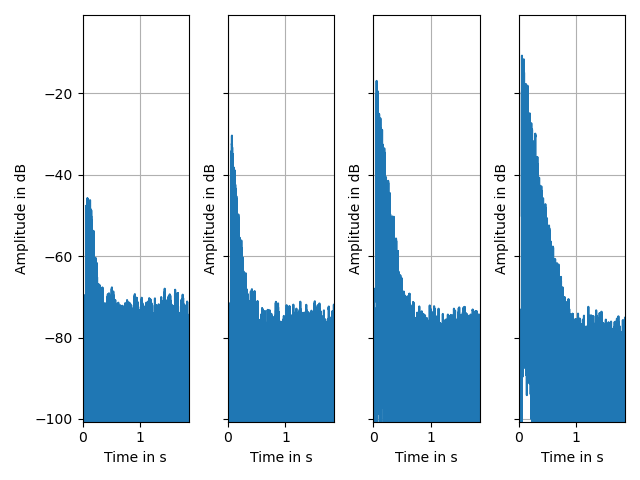

In [23]:
bands = [250, 500, 1e3, 2e3]

fig, axs = plt.subplots(1, len(bands), sharey=True, sharex=True)

for idx, band in enumerate(bands):
    RIR_bandpass = pf.dsp.filter.fractional_octave_bands(
        RIRs_cropped[0], 1, freq_range=np.array([0.9, 1.1])*band)
    pf.plot.time(RIR_bandpass, dB=True, ax=axs[idx])
    axs[idx].grid(True)

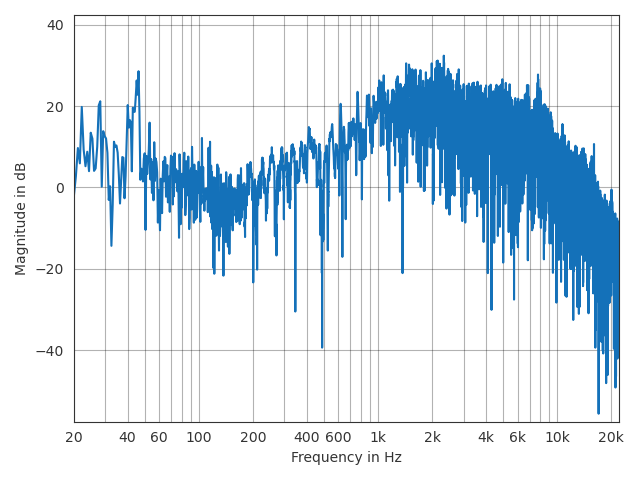

In [24]:
plt.figure()
pf.plot.freq(RIRs_cropped[0]);

#

# Auswertung in Terzen

In [25]:
freq_range = (500, 15e3)

rirs_bands = pf.dsp.filter.fractional_octave_bands(
    RIRs_cropped[0], 3, freq_range=freq_range)

bands = pf.dsp.filter.fractional_octave_frequencies(3, frequency_range=freq_range)[0]

edcs = pyrato.energy_decay_curve_chu_lundeby(rirs_bands)
rts = pyrato.reverberation_time_linear_regression(edcs)

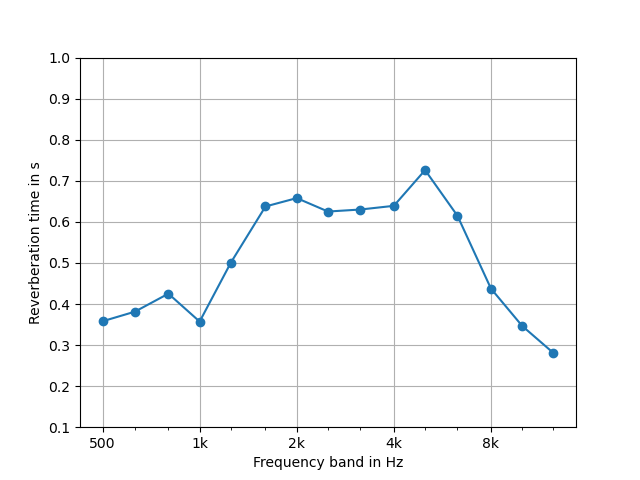

In [26]:
plt.figure()
ax = plt.axes()
ax.semilogx(bands, rts, marker='o')
ax.grid(True)
attach_fractional_octave_ticker(ax, 1, 3)
ax.set_ylabel("Reverberation time in s")
ax.set_xlabel("Frequency band in Hz")
ax.set_ylim((0.1, 1));